In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, explained_variance_score, mean_absolute_error, mean_squared_error
%matplotlib inline 

In [3]:
from mll_calc.all_jobs import uncs, job_dirs

### hi hello

In [4]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
mll_gam = rdrive + 'mll/gam_spec/'
mll_nuc = rdrive + 'mll/nuc_conc/'
learn_gam = rdrive + 'scikit/gam_spec/'
learn_nuc = rdrive + 'scikit/nuc_conc/'

In [5]:
#mll results for uncertainty = 5% (trainset frac = 100%)
#scikit results for trainset frac = 100% (no uncertainty)

In [6]:
job = job_dirs[0]
n29mll = pd.read_csv(mll_nuc + 'train/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d1mll = pd.read_csv(mll_gam + 'd1_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d2mll = pd.read_csv(mll_gam + 'd2_n113/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
mll_df = [n29mll, d1mll, d2mll]

d1mll31 = pd.read_csv(mll_gam + 'd1_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d2mll31 = pd.read_csv(mll_gam + 'd2_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
d3mll31 = pd.read_csv(mll_gam + 'd3_n31/' + job + '/' + job + '.csv').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
mll31 = [n29mll, d1mll31, d2mll31, d3mll31]

In [21]:
n29mll.columns

Index(['sim_idx', 'ReactorType', 'CoolingTime', 'Enrichment', 'Burnup',
       'OrigenReactor', 'AvgPowerDensity', 'ModDensity', 'UiWeight',
       'pred_idx', 'pred_ReactorType', 'pred_CoolingTime', 'pred_Enrichment',
       'pred_Burnup', 'pred_OrigenReactor', 'pred_AvgPowerDensity',
       'pred_ModDensity', 'pred_UiWeight', 'MaxLogLL', 'MaxLLUnc',
       '2ndMaxLogLL', '2ndMaxLLUnc', 'CDF_LogLL_0.9998', 'CDF_LLUnc_0.9998',
       'CDF_LogLL_0.9988', 'CDF_LLUnc_0.9988', 'CDF_LogLL_0.95',
       'CDF_LLUnc_0.95', 'CDF_LogLL_0.9', 'CDF_LLUnc_0.9', 'CDF_LogLL_0.5',
       'CDF_LLUnc_0.5', 'CDF_LogLL_0.1', 'CDF_LLUnc_0.1', 'CDF_LogLL_0.01',
       'CDF_LLUnc_0.01', 'ReactorType_Score', 'CoolingTime_Error',
       'Enrichment_Error', 'Burnup_Error', 'OrigenReactor_Score'],
      dtype='object')

In [13]:
det = ['nuc29','d1', 'd2', 'd3']
detdesc = ['nuc29', 'd1_hpge', 'd2_hpge', 'd3_czt']
pred = ['reactor', 'burnup', 'enrichment', 'cooling']
predmll = ['ReactorType', 'Burnup', 'Enrichment', 'CoolingTime']
csv_end = '_scores.csv'
# for dataframes
algcol = ['knn', 'dtree', 'mll', 'knn31', 'dtree31', 'mll31', 'pca_knn', 'pca_dtree']
scrcol  = ['Accuracy', 'Acc Std']
errcol = ['Neg MAE', 'MAE Std']

In [22]:
results = {}
for i, p in enumerate(pred):
    if p == 'reactor':
        levels = [algcol, scrcol]
    else: 
        levels = [algcol, errcol]
    df = pd.DataFrame(index=det, columns=pd.MultiIndex.from_product(levels, names=["Algorithm", "Metric"]))
    for j, d in enumerate(det):
        knncsv = p + '_knn_tset1.0_' + detdesc[j] + csv_end
        dtrcsv = p + '_dtree_tset1.0_' + detdesc[j] + csv_end
        if d == 'nuc29':
            learn_path = learn_nuc
            # knn113 and knn31 will both have knn nuc 29 as their starting points
            knn31 = knn113 = pd.read_csv(learn_path + d + '/' + knncsv).drop(columns='Unnamed: 0')
            dtr31 = dtr113 = pd.read_csv(learn_path + d + '/' + dtrcsv).drop(columns='Unnamed: 0')
        else:
            learn_path = learn_gam
            knn31 = pd.read_csv(learn_path + d + '_n31/' + knncsv).drop(columns='Unnamed: 0')
            dtr31 = pd.read_csv(learn_path + d + '_n31/' + dtrcsv).drop(columns='Unnamed: 0')
            if d != 'd3':
                knn113 = pd.read_csv(learn_path + d + '_n113/' + knncsv).drop(columns='Unnamed: 0')
                dtr113 = pd.read_csv(learn_path + d + '_n113/' + dtrcsv).drop(columns='Unnamed: 0')
        pcaknn = pd.read_csv(learn_path + 'pca_' + d + '/' + knncsv).drop(columns='Unnamed: 0')
        pcadtr = pd.read_csv(learn_path + 'pca_' + d + '/' + dtrcsv).drop(columns='Unnamed: 0')
        if p == 'reactor':
            metric = 'test_score'
            dfmetric = 'Accuracy'
            dfstd = 'Acc Std'
            if d != 'd3':
                df.loc[d, ('mll', dfmetric)] = accuracy_score(mll_df[j][predmll[i]], mll_df[j]['pred_' + predmll[i]])
                df.loc[d, ('mll', dfstd)] = np.std(mll_df[j][predmll[i] + '_Score'])
            df.loc[d, ('mll31', dfmetric)] = accuracy_score(mll31[j][predmll[i]], mll31[j]['pred_' + predmll[i]])
            df.loc[d, ('mll31', dfstd)] = np.std(mll31[j][predmll[i] + '_Score'])
        else:
            metric = 'test_neg_mean_absolute_error'
            dfmetric = 'Neg MAE'
            dfstd = 'MAE Std'
            if d != 'd3':
                df.loc[d, ('mll', dfmetric)] = -mean_absolute_error(mll_df[j][predmll[i]], mll_df[j]['pred_' + predmll[i]])
                df.loc[d, ('mll', dfstd)] = np.std(mll_df[j][predmll[i] + '_Error'])
            df.loc[d, ('mll31', dfmetric)] = -mean_absolute_error(mll31[j][predmll[i]], mll31[j]['pred_' + predmll[i]])
            df.loc[d, ('mll31', dfstd)] = np.std(mll31[j][predmll[i] + '_Error'])
        if d != 'd3':
            df.loc[d, ('knn', dfmetric)] = knn113[metric].mean()
            df.loc[d, ('knn', dfstd)] = knn113[metric].std()
            df.loc[d, ('dtree', dfmetric)] = dtr113[metric].mean()
            df.loc[d, ('dtree', dfstd)] = dtr113[metric].std()    
        df.loc[d, ('pca_knn', dfmetric)] = pcaknn[metric].mean()
        df.loc[d, ('pca_knn', dfstd)] = pcaknn[metric].std()
        df.loc[d, ('pca_dtree', dfmetric)] = pcadtr[metric].mean()
        df.loc[d, ('pca_dtree', dfstd)] = pcadtr[metric].std()    
        df.loc[d, ('knn31', dfmetric)] = knn31[metric].mean()
        df.loc[d, ('knn31', dfstd)] = knn31[metric].std()
        df.loc[d, ('dtree31', dfmetric)] = dtr31[metric].mean()
        df.loc[d, ('dtree31', dfstd)] = dtr31[metric].std()
    results[p] = df

In [35]:
results['burnup']

Algorithm      knn                dtree                 mll             knn31  \
Metric     Neg MAE   MAE Std    Neg MAE    MAE Std  Neg MAE  MAE Std  Neg MAE   
nuc29     -13.3255  0.399027 -0.0428527  0.0121613 -102.214  326.214 -13.3255   
d1        -371.227    2.6726   -241.972    3.61563  -283.35  800.081  -380.38   
d2        -428.514   2.52542   -269.008    1.64982 -343.381  964.866  -423.59   
d3             NaN       NaN        NaN        NaN      NaN      NaN -447.625   

Algorithm              dtree31               mll31           pca_knn           \
Metric      MAE Std    Neg MAE    MAE Std  Neg MAE  MAE Std  Neg MAE  MAE Std   
nuc29      0.399027 -0.0428527  0.0121613 -102.214  326.214 -79.8074  0.76193   
d1          2.76273   -278.263     2.7957 -286.503  819.577 -795.875  5.86567   
d2          3.29947   -295.575    3.19498 -340.317  939.614 -517.191  2.71232   
d3          3.98391    -337.61    4.33915 -412.104  1083.93  -457.12  2.95211   

Algorithm pca_dtree           
Metric      Neg MAE  MAE Std  
nuc29      -107.215   1.6142  
d1         -941.906  5.57807  
d2          -568.62  3.33551  
d3         -539.756  3.88002

# Plotting

In [18]:
# color dict (use: colors['XColor'])
colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

In [107]:
def plot_curves(pred_param, title):
    plt.clf()
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=20, pad=15)
    ax.set_xlabel('Detector Type', fontsize=20, labelpad=15)
    if pred_param == 'reactor':
        ax.set_ylabel('Accuracy Score', fontsize=20, labelpad=15)
        metric = scrcol[0]
        std = scrcol[1]
    else:
        err = 'Negative MAE'
        if pred_param == 'burnup':
            yaxlbl = err + ' [MWd/MTU]'
        elif pred_param == 'enrichment':
            yaxlbl = err + ' [% U235]'
        else:
            yaxlbl = err + ' [days]'
        ax.set_ylabel(yaxlbl, fontsize=20, labelpad=15)
        metric = errcol[0]
        std = errcol[1]
    
    plotdf = results[pred_param].iloc[1:]
    x = ['Lab HPGe', 'Portable HPGe', 'CZT']#plotdf.index.tolist() 'Nuclide Mass', 
    # algcol above is: 
    # ['knn', 'dtree', 'mll', 'knn31', 'dtree31', 'mll31', 'pca_knn', 'pca_dtree']
    # bad form order of lists impt: 
    c = ['DBrwn', 'DTeal', 'DPurp', 'MBrwn', 'MTeal', 'MPurp', 'LBrwn', 'LTeal']
    lbl = ['kNN 113', 'Dec Tree 113', 'MLL Calc 113', 'kNN 31', 'Dec Tree 31', 'MLL Calc 31', 'PCA kNN', 'PCA Dec Tree']
    for i, alg in enumerate(algcol[0:-2]):
        y = np.array(plotdf[alg][metric])
        sd = np.array(plotdf[alg][std])
        ax.plot(x, y, 'o-', color=colors[c[i]], mew=0, ms=5, label=lbl[i])
        #ax.fill_between(x, y - sd, y + sd, interpolate=True, color=c[i], alpha=0.2)
    
    ax.tick_params(labelsize=14)
    h,l = ax.get_legend_handles_labels()
    handles = [h[5], h[2], h[3], h[0], h[4], h[1]]#, h[6], h[7]]
    labels = [l[5], l[2], l[3], l[0], l[4], l[1]]#, l[6], l[7]]
    ax.legend(handles,labels,loc='best')
    plt.show()
    
    sv_fig = '../plots/final2021/detector_preds_' + pred_param + '.png'
    fig.savefig(sv_fig, bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

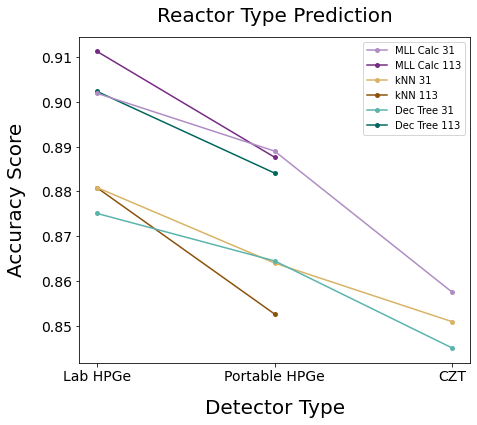

In [108]:
plot_curves('reactor', 'Reactor Type Prediction')

<Figure size 432x288 with 0 Axes>

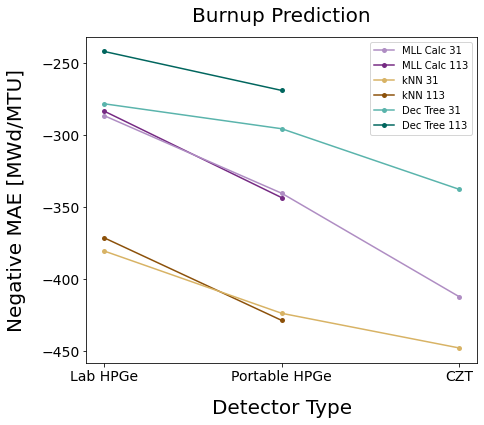

In [109]:
plot_curves('burnup', 'Burnup Prediction')

<Figure size 432x288 with 0 Axes>

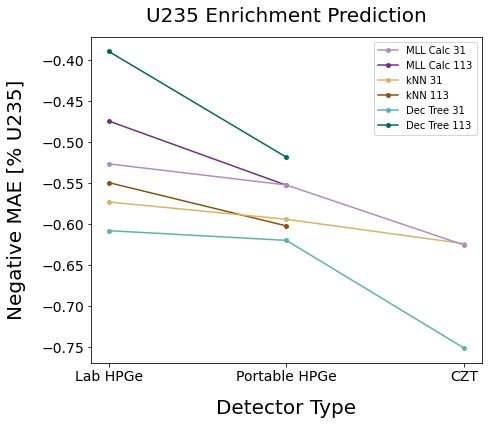

In [110]:
plot_curves('enrichment', 'U235 Enrichment Prediction')

<Figure size 432x288 with 0 Axes>

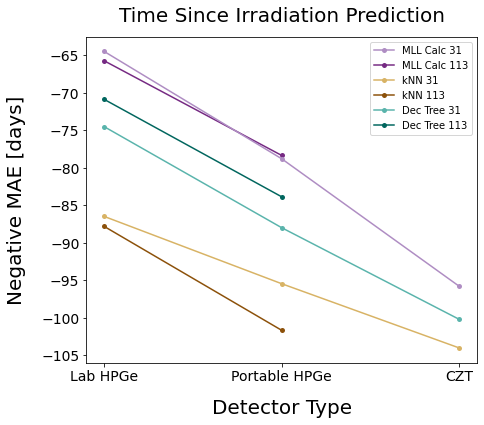

In [111]:
plot_curves('cooling', 'Time Since Irradiation Prediction')

## adding nuclide conc on x axis

<Figure size 432x288 with 0 Axes>

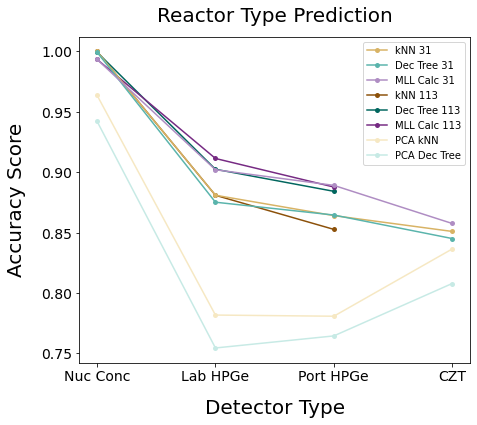

In [74]:
plot_curves('reactor', 'Reactor Type Prediction')

<Figure size 432x288 with 0 Axes>

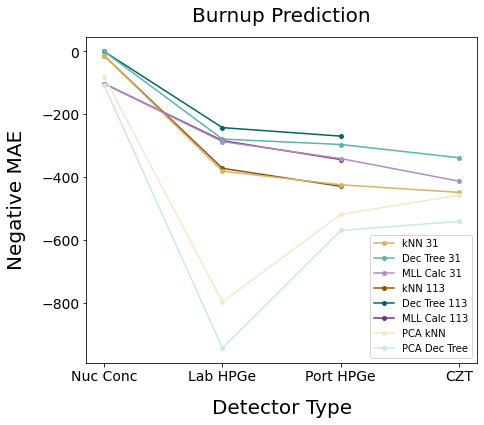

In [75]:
plot_curves('burnup', 'Burnup Prediction')

<Figure size 432x288 with 0 Axes>

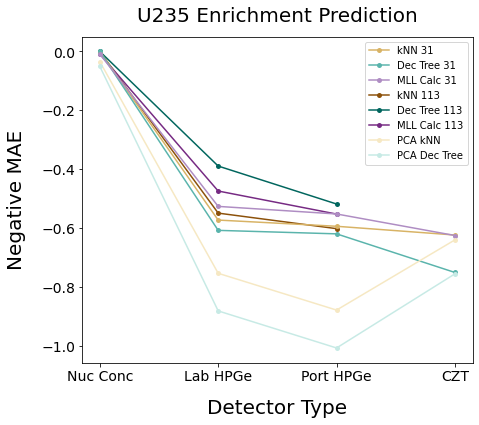

In [76]:
plot_curves('enrichment', 'U235 Enrichment Prediction')

<Figure size 432x288 with 0 Axes>

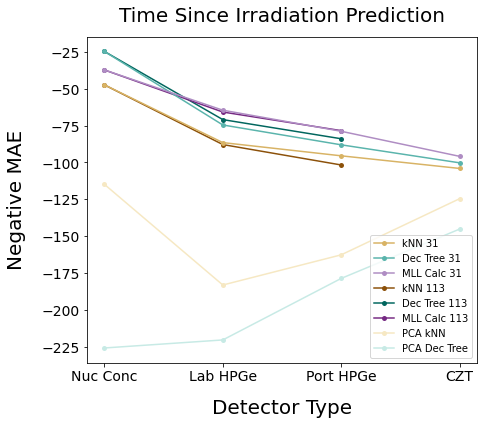

In [77]:
plot_curves('cooling', 'Time Since Irradiation Prediction')